In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [4]:
# Import the data
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
train_data_gs, test_data_gs = (
    tf.image.rgb_to_grayscale(train_data).numpy(),
    tf.image.rgb_to_grayscale(test_data).numpy()
)

2022-04-01 17:56:59.201186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


In [5]:
from utils.dataset import get_data_masks
import numpy as np

# load the model
classifier = tf.keras.models.load_model('../in/digit_classifier')

# load the predictions
predictions = np.loadtxt('../in/predictions.csv')
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))

# get the masks for the data
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5, verbose=True)


Found 892/10000 instances for the label 5
Found 13/892 instances for misclassified 5
        


In [6]:
base_dir = '../out/approaches/global_latent'

# Experiment with different configurations
Try different approaches for clustering the explanations.

In [12]:
from utils.general import beep
from xplique.attributions import GradCAMPP
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from workflow.ClusteringMode import GlobalLatentMode
from workflow.tuning import find_optimal_clusters

# generate the explanations
approaches = [
    GlobalLatentMode(
        mask=mask_label,
        explainer=GradCAMPP(classifier),
        dim_red_techs=[TSNE(perplexity=perplexity)],
        clus_tech=AffinityPropagation()
    )
    for perplexity in [.1, .5, 1, 3, 5, 7, 10, 15, 20, 30]
]
df = find_optimal_clusters(
    approaches=approaches,
    data=test_data,
    predictions=predictions_cat,
    iterations=5,
    verbose=True
)

beep()


APPROACH: GlobalLatentMode
EXPLAINER: GradCAMPP
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 0.1, 'random_state': None, 'square_distances': 'legacy', 'verbose': 0}]
            
1/5 -> 0.3763996660709381
2/5 -> NO CLUSTERS
3/5 -> NO CLUSTERS
4/5 -> NO CLUSTERS
5/5 -> NO CLUSTERS

APPROACH: GlobalLatentMode
EXPLAINER: GradCAMPP
CLUS TECH: AffinityPropagation
DIM RED TECH: ['TSNE']
DIM RED TECH PARAMS: [{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 0.5, 'random_state': None, 'square_distances': 'legacy', 'v

In [19]:
from utils.general import save_figure
import seaborn as sns
import matplotlib.pyplot as plt

# add a column with the perplexity value
df['PERPLEXITY'] = df['DIMENSIONALITY_REDUCTION_TECHNIQUE_PARAMS'].apply(lambda params: float(params[0]['perplexity']))
# generate the boxplot for the different perplexity values
fig = plt.figure(figsize=(16, 9))
sns.boxplot(x='PERPLEXITY', y='SILHOUETTE', data=df, color='gray').set_title(
    """
GradCAM++ - Affinity Propagation Clustering (Euclidean distance)
Silhouette score by perplexity for clusters in the Local Latent Space
    """
)
save_figure(fig, f'{base_dir}/silhouette_by_perplexity')

NameError: name 'df' is not defined

# Plot the cluster in the lower dimensional space

In [15]:
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from workflow.ClusteringMode import GlobalLatentMode
from xplique.attributions import GradCAMPP
from utils.general import beep

# create the approach corresponding to the best configuration
approach = GlobalLatentMode(
    mask=mask_label,
    explainer=GradCAMPP(classifier),
    clus_tech=AffinityPropagation(),
    dim_red_techs=[TSNE(perplexity=6)]
)
# generate the contributions
contributions = approach.generate_contributions(test_data, predictions_cat)
# cluster the contributions
clusters, score, projections = approach.cluster_contributions(contributions)
print('Silhouette score: ', round(score, 3))
beep()

Silhouette score:  0.361


In [16]:
# create the mask for the misclassified items of the selected label
mask_miss_label = mask_miss[mask_label]
# create the mask for the clusters containing misclassified elements of the selected label
mask_contains_miss_label = np.isin(clusters, np.unique(clusters[mask_miss_label]))

NameError: name 'save_figure' is not defined

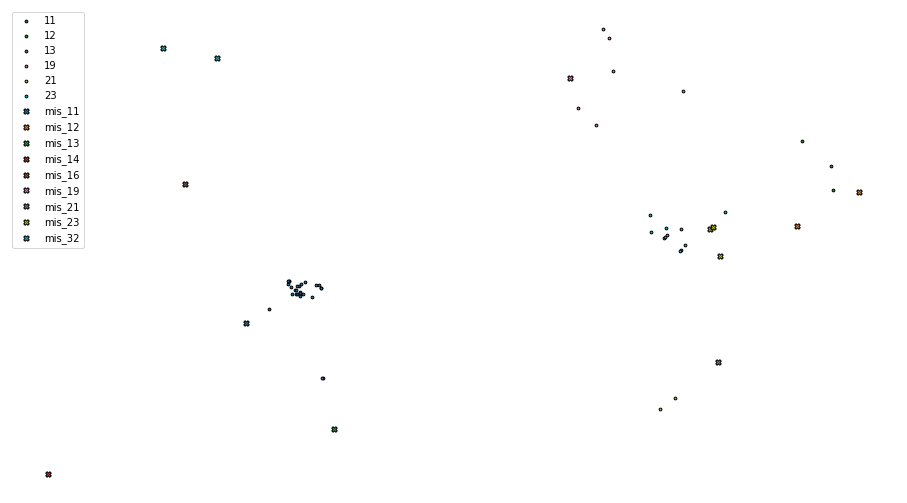

In [17]:
from utils.cluster.visualize import visualize_clusters_projections

# visualize the projections of the contributions for the correct predictions
fig, ax = visualize_clusters_projections(
    projections=projections[~mask_miss_label & mask_contains_miss_label],
    clusters=clusters[~mask_miss_label & mask_contains_miss_label],
    cmap='tab10', marker='.'
)
# visualize the projections of the contributions for the wrong predictions
visualize_clusters_projections(
    projections=projections[mask_miss_label],
    clusters=clusters[mask_miss_label],
    fig=fig, ax=ax, cmap='tab10', marker='X', label_prefix='mis'
)

# ax.set_title('Projections for the clusters containing both correct and incorrect classifications')
save_figure(fig, f'{base_dir}/clusters_projections')

In [25]:
mask_contains_miss_label.shape, mask_label.shape, mask_miss.shape, mask_miss_label.shape

((892,), (10000,), (10000,), (892,))

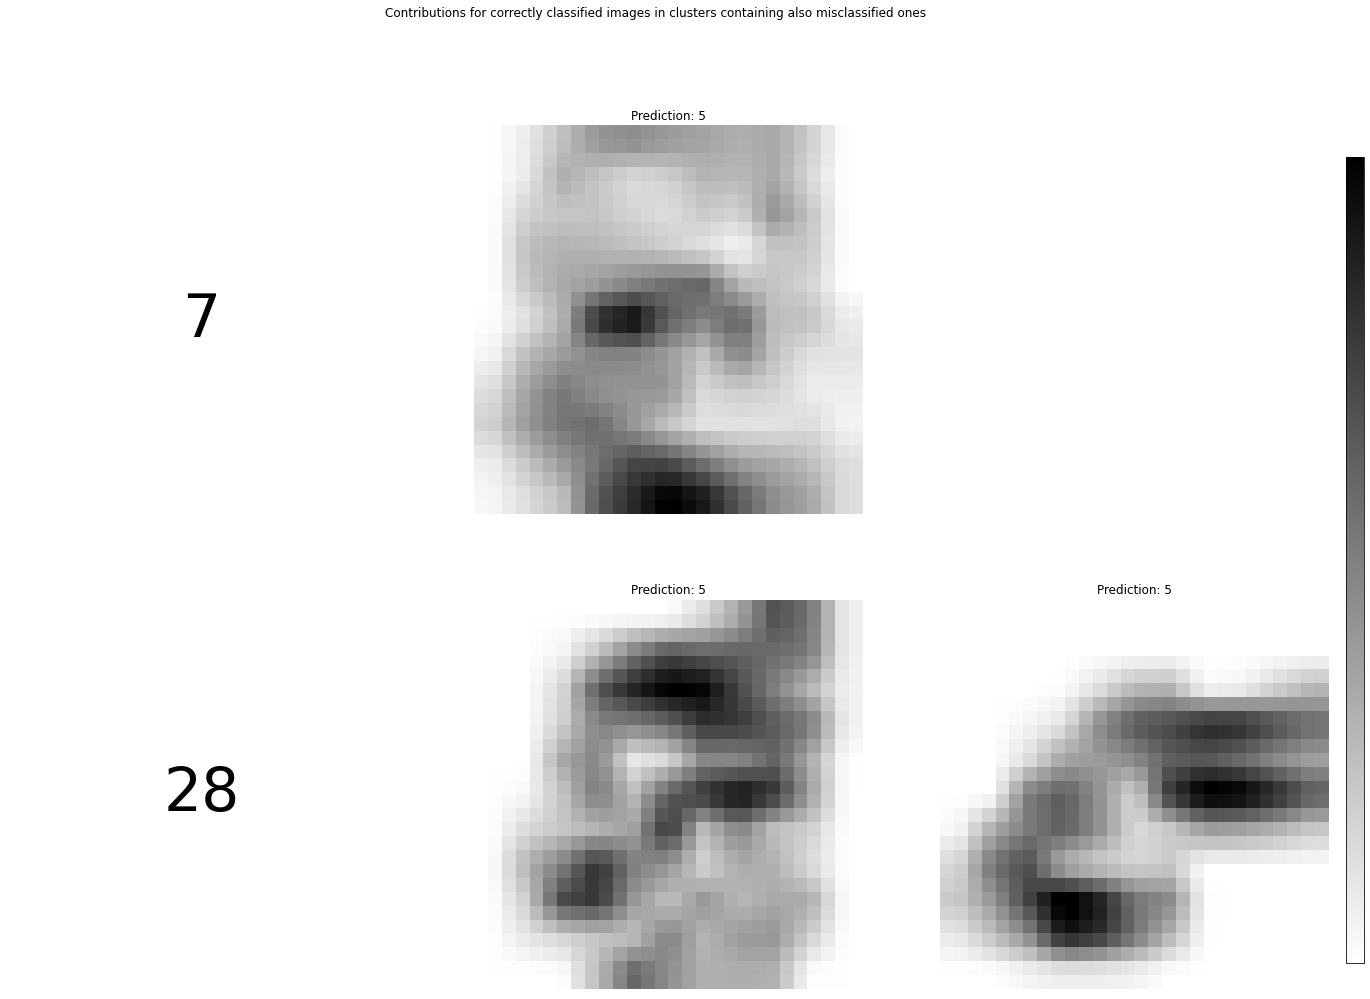

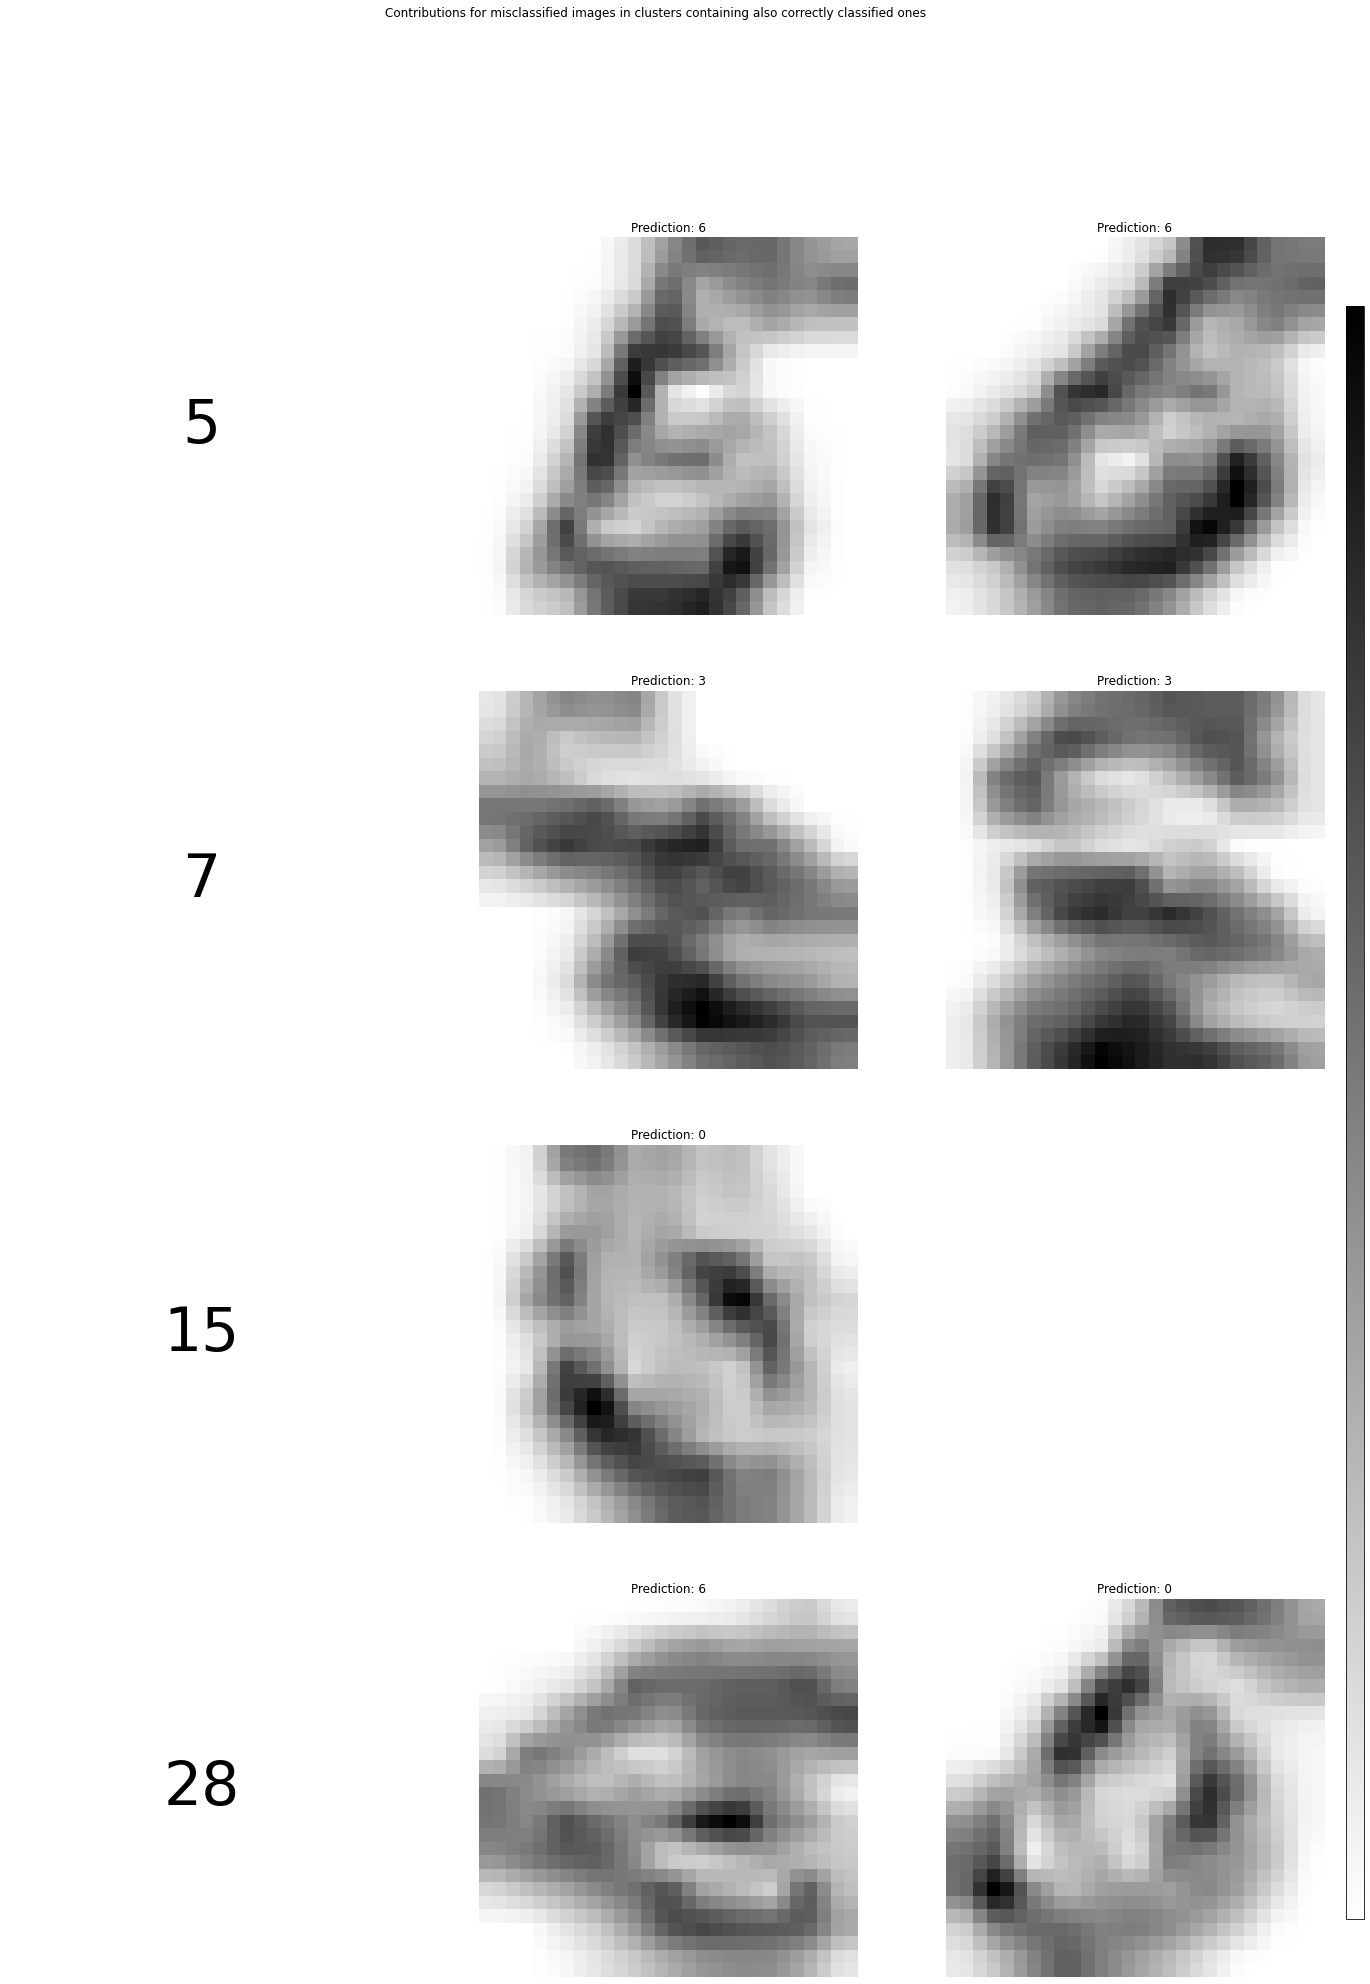

In [26]:
from utils.cluster.visualize import visualize_clusters_images

# sample some clusters labels containing misclassified items
sample_labels = np.random.choice(np.unique(clusters[mask_contains_miss_label]), 4, replace=False)

sample_mask = np.isin(clusters, sample_labels)
# show some correctly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & ~mask_miss_label & sample_mask],
    images=contributions[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
fig.suptitle('Contributions for correctly classified images in clusters containing also misclassified ones')
save_figure(fig, f'{base_dir}/clusters_correct_contributions')
# show some incorrectly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & mask_miss_label & sample_mask],
    images=contributions[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
fig.suptitle('Contributions for misclassified images in clusters containing also correctly classified ones')
save_figure(fig, f'{base_dir}/clusters_misclassified_contributions')

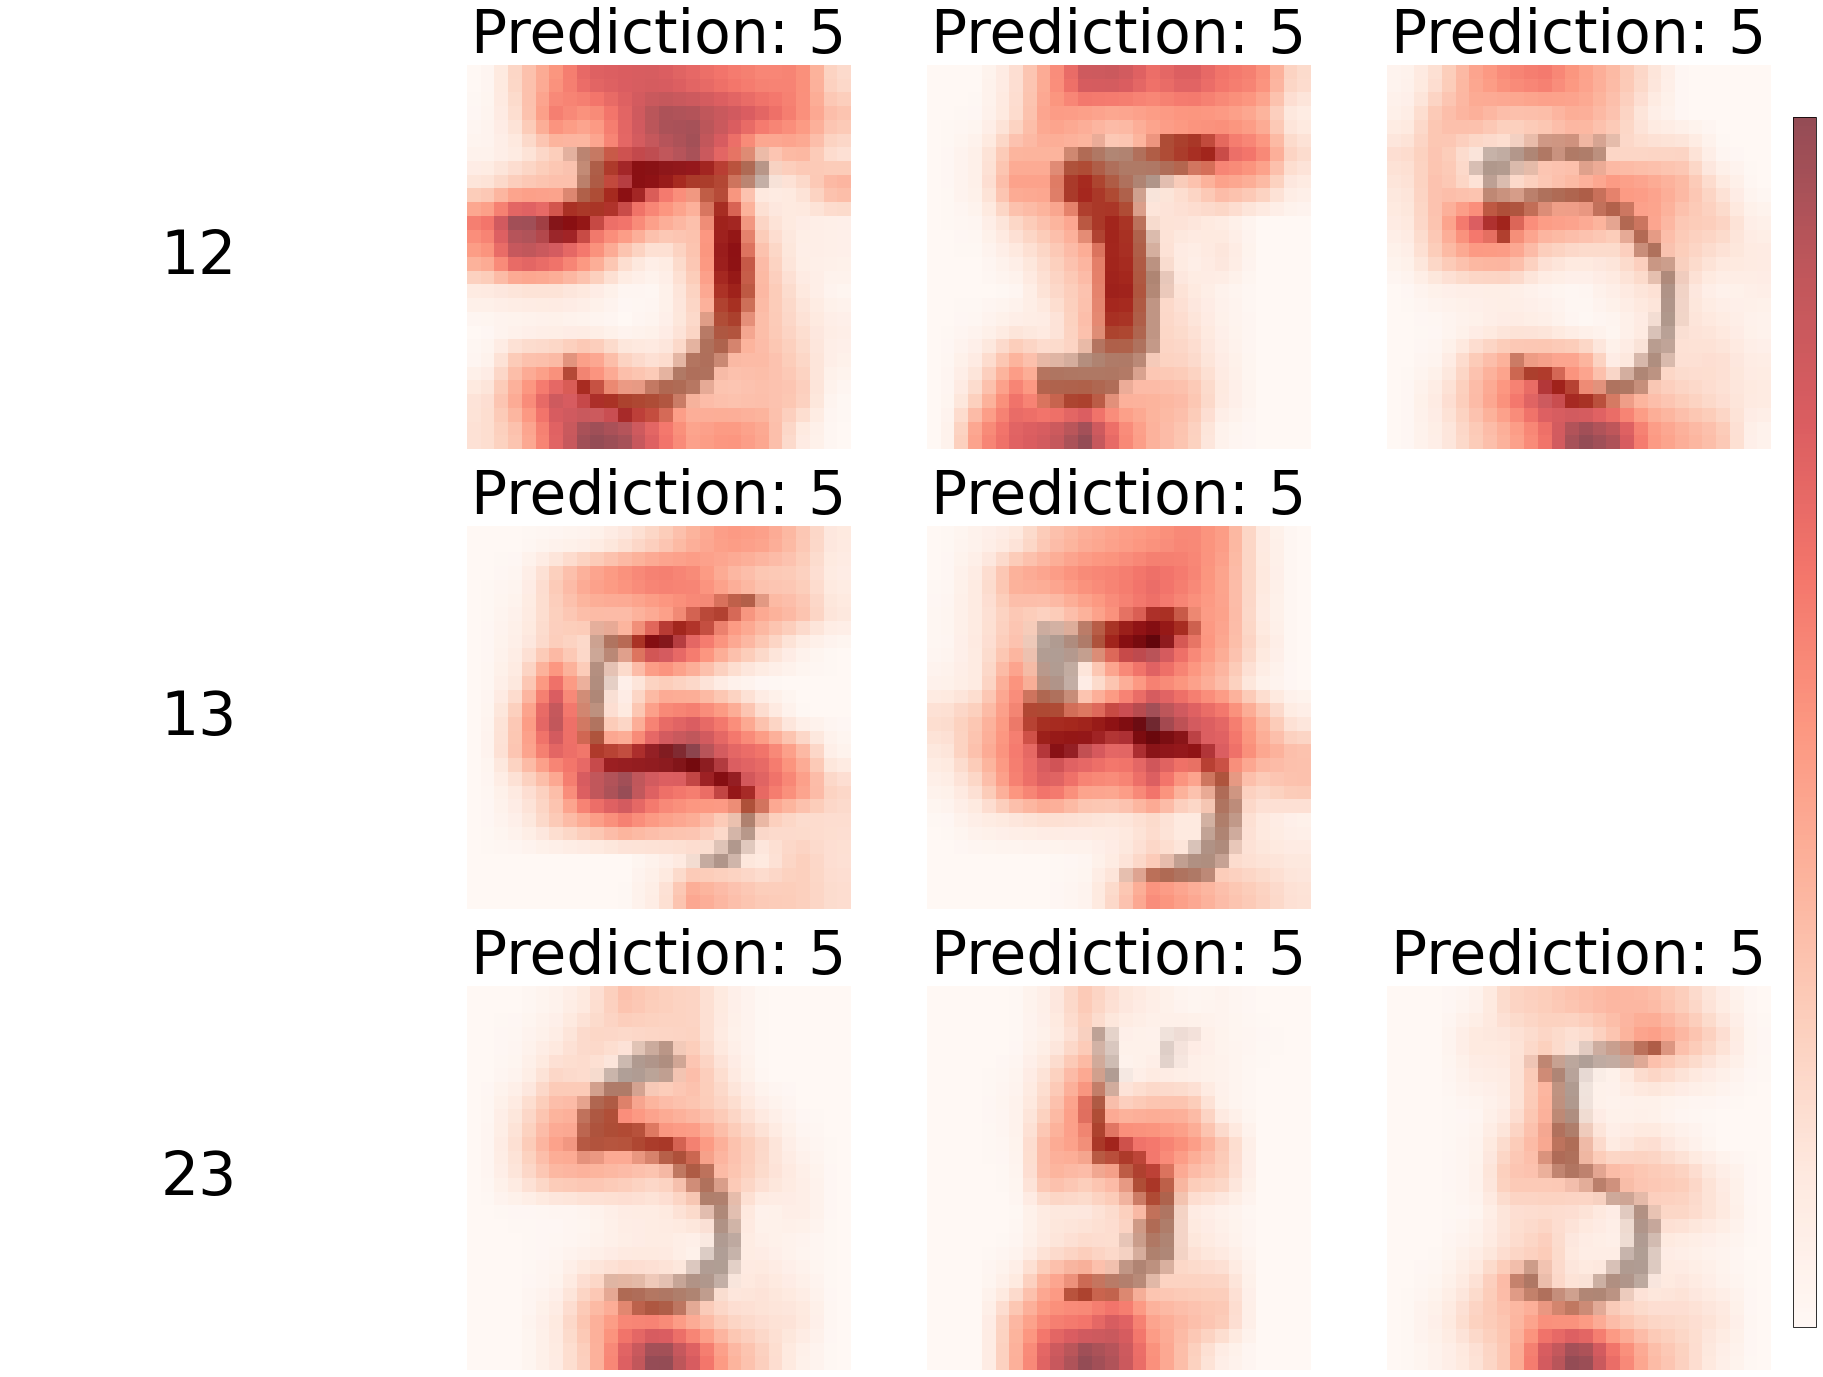

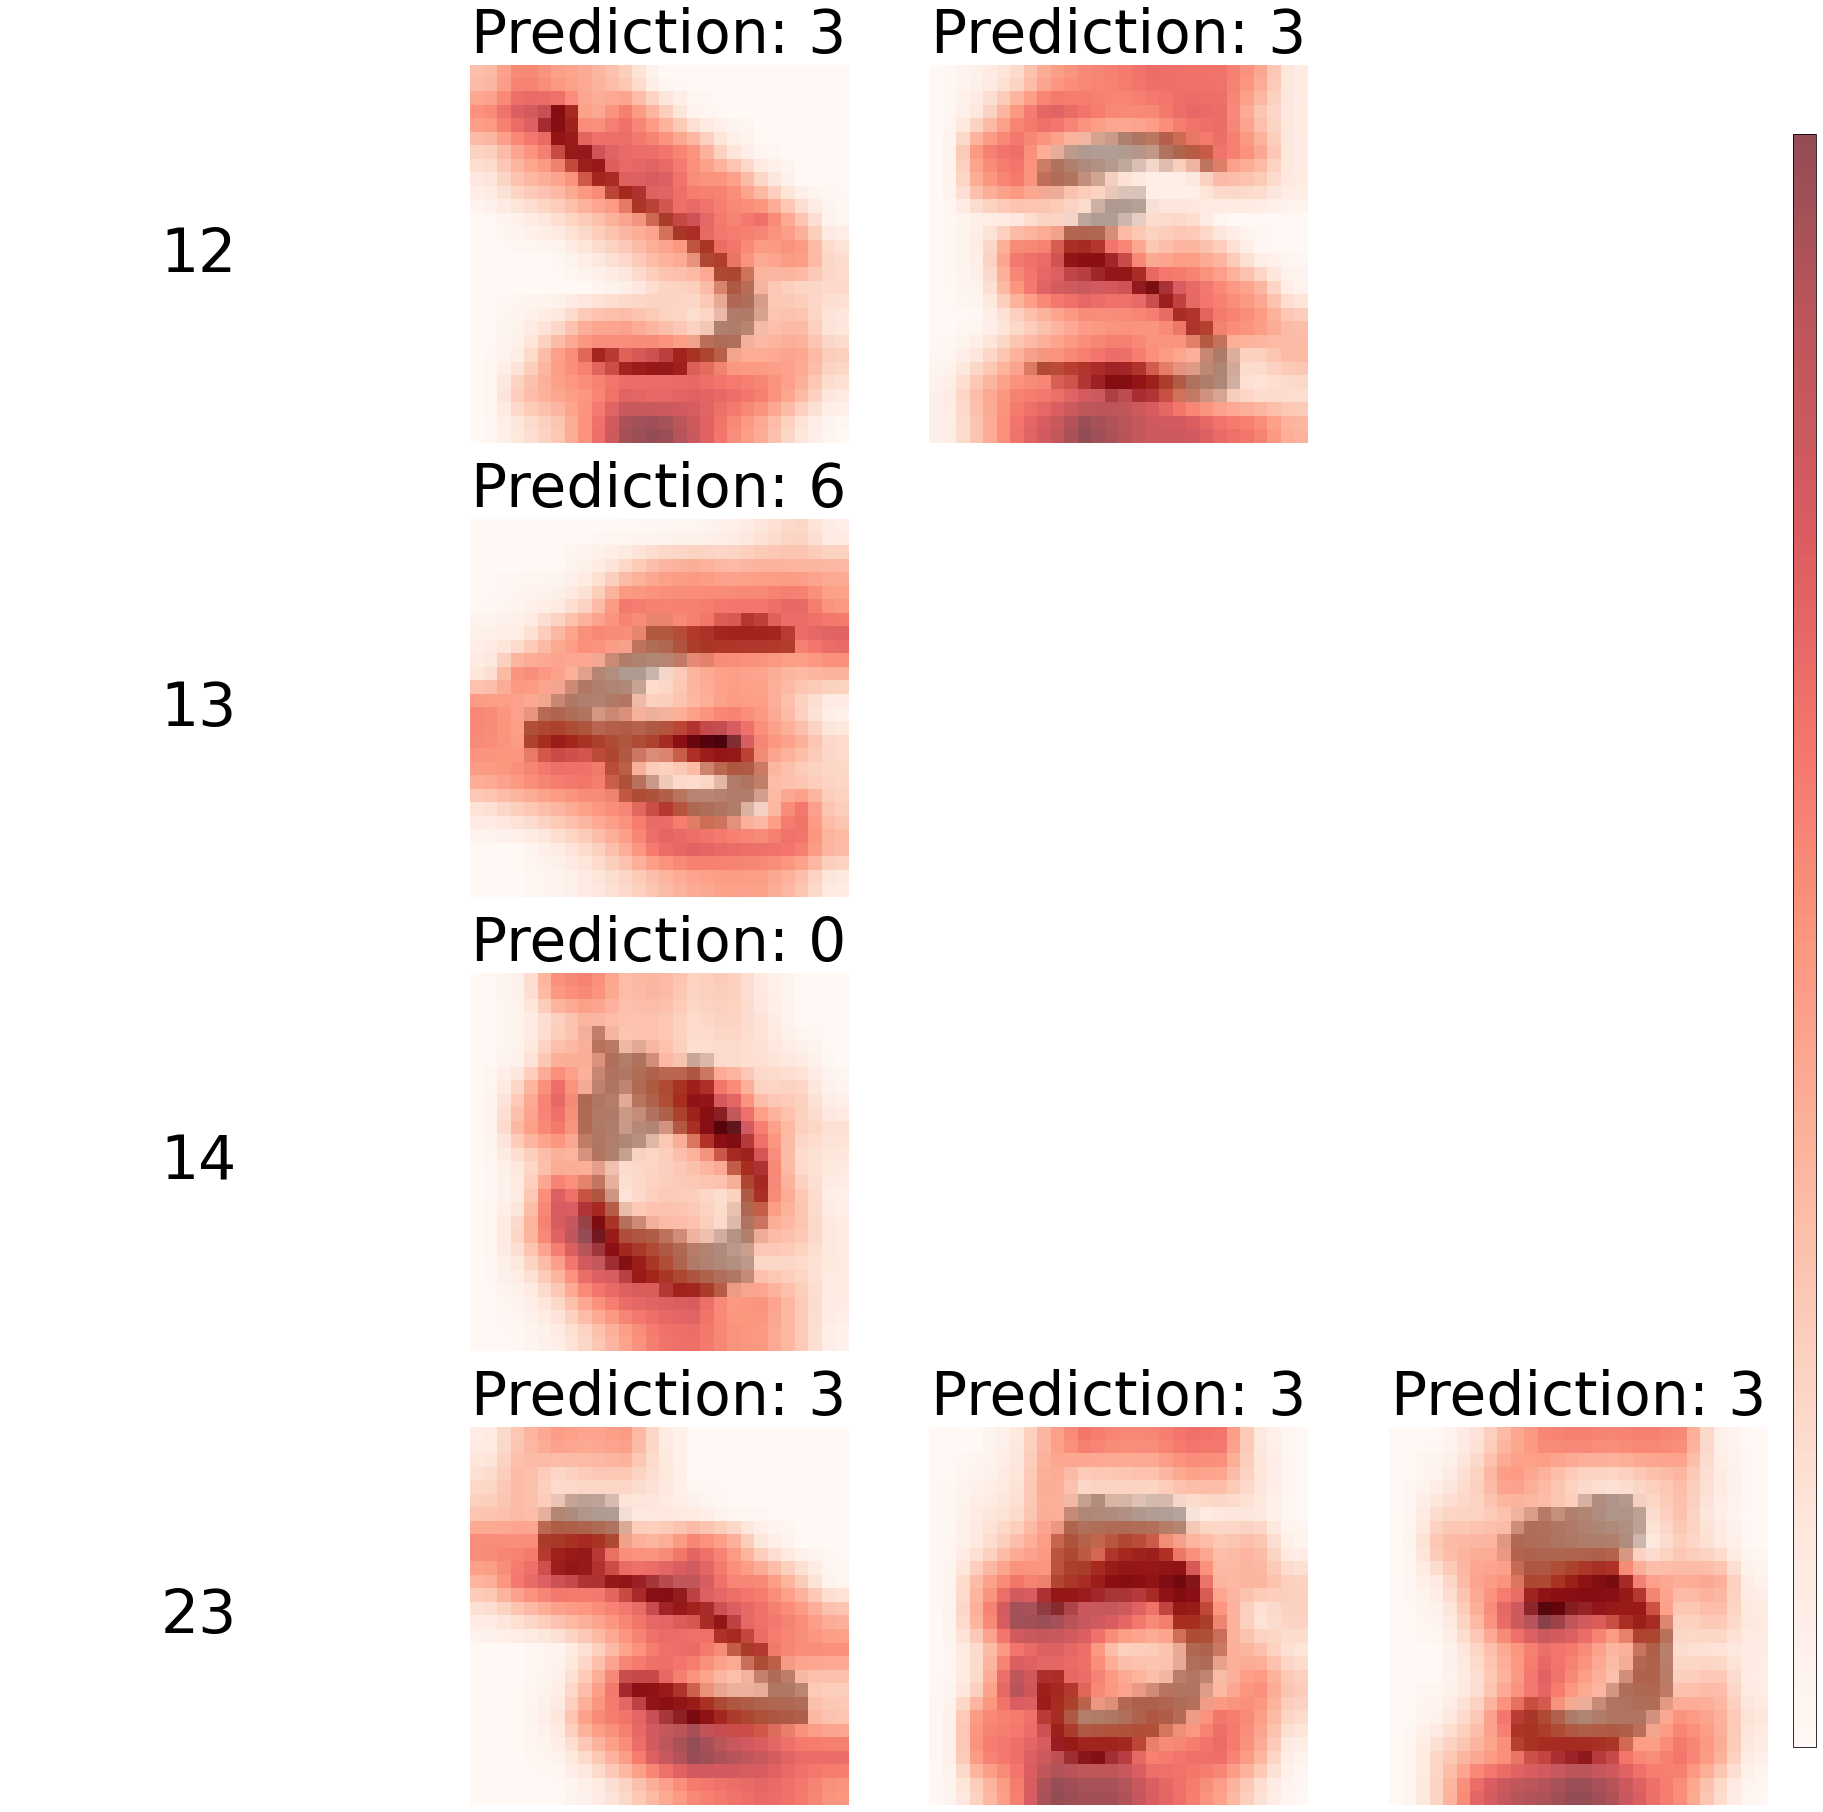

In [28]:
from utils.cluster.visualize import visualize_clusters_images
import numpy as np

# sample some clusters labels containing misclassified items
sample_labels = np.random.choice(np.unique(clusters[mask_contains_miss_label]), 4, replace=False)

sample_mask = np.isin(clusters, sample_labels)
# show some correctly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & ~mask_miss_label & sample_mask],
    images=test_data_gs[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    overlay=contributions[mask_label][mask_contains_miss_label & ~mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
save_figure(fig, f'{base_dir}/clusters_correct_images')
# show some incorrectly classified images for clusters containing also misclassified images
fig, _ = visualize_clusters_images(
    clusters=clusters[mask_contains_miss_label & mask_miss_label & sample_mask],
    images=test_data_gs[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    predictions=predictions[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    overlay=contributions[mask_label][mask_contains_miss_label & mask_miss_label & sample_mask],
    max_labels=4, max_samples=3,
    cmap='gray_r'
)
save_figure(fig, f'{base_dir}/clusters_misclassified_images')